# **Finding Paths in Graphs Using Grover's Algorithm**



Grover's Algorithm is a quantum database search algorithm [1]. Finding one or more solutions to a problem can be solved in $O(\sqrt{N}/t)$ steps, where $t$ is the number of solutions. In this tutorial, you will be shown how to find paths from one vertex to another in an undirected graph $G(V,E)$. If the state is prepared and measured $N$ times, the probability distribution shows all possible paths from one vertex to another. The solutions found are paths where none of the vertices is visited more than once.



##### **References:**

[1]: GROVER, Lov. A fast quantum mechanical algorithm for database search. Título da Revista, Bell Labs, Murray Hill NJ, May, 1996. Available in: arXiv:quant-ph/9605043.



### **The Problem**

<img src="g2.jpeg" width="250" height="200" />

Given a graph $G(v,e)$ with $v$ vertices and $e$ edges. The objective of this work is to use Grover's algorithm to search all paths between two vertices of $G(v,e)$ with time complexity $O(\sqrt{v} /t)$. The encoding can be done so that the edges and vertices are represented as qubits in different registers. An untraveled edge remains in state $'0'$ while the traversed edge reverses its state to $'1'$. The vertices, on the other hand, invert their states if the edge connecting them has been traversed. Thus, if a path is traversed in the graph, the vertices in state $'1'$ will be just the starting and ending points of the path. The following image illustrates why the previous statement is valid.


<img src="g2.jpeg" width="1000" height="200" />

The graph on the far right shows us the solution to the problem. The state of the edges $'0011011'$ shows us the Hamiltonian path, while the states of the vertices $'10100'$ show us what the final configuration of the vertices is for the path to be found. We see that, in a graph with $n$ vertices, the Hamiltonian path passes through $n−1$ edges.

### **Running the algorithm**

First, we need to specify how many vertices and edges the graph has. Two registers must be created so that: In the register where the measurements will be taken, each qubit represents an edge. In the other register, each qubit represents a vertex.

In [ ]:
import qiskit
from qiskit import *
from qiskit.visualization import *

# define the variables vertices (v) and edges (e)
v, e = 5, 7 

edge = QuantumRegister(e, 'edge')
vertex = QuantumRegister(v, 'vertex')
ancilla = QuantumRegister(1, 'ancilla')
cr = ClassicalRegister(e, 'cr')
qc = QuantumCircuit(edge,vertex,ancilla,cr)

In [ ]:
def initialize():
    init = QuantumCircuit(edge,vertex,ancilla)
    init.h(range(len(edge)))
    init.x(ancilla[0])
    init.h(ancilla[0])
    init.barrier()
    return init

We start by adding all the $2^m$ possible paths that exist in the graph. The way to do this is to apply the operation $H^{\otimes m}$ on the qubits representing the edges


$$|\psi\rangle = \frac{1}{\sqrt{2^m}} \sum |x\rangle \otimes |0\rangle^{\otimes n}|-\rangle$$

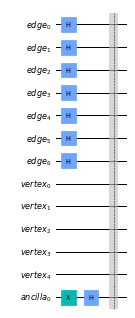

In [ ]:
initialize().draw('mpl', scale=0.5)

We can code the graph as a quantum circuit, using CX operations, so that if the control is set to '1' (traveled path), the target reverses its state (vertices). In this way, we will have the following resulting state

\begin{equation}
|\psi\rangle = \frac{1}{\sqrt{2^m}} \sum |x\rangle \otimes |y\rangle
\end{equation}

where $y_i$ is the vertex configuration for a path $x_i$ traversed. Now, let's create the function that encodes the graph as a quantum circuit that works with the state changes at the vertices according to the edges traversed. The graph we'll use as an example in this tutorial is the one in the following image, where the index of each vertex and each edge corresponds to the qubits of the respective registers


<img src="g1.jpeg" width="250" height="100" />

In [ ]:
def graph_encoding():
    
    graph = QuantumCircuit(edge,vertex)
    
    graph.cx(edge[0],vertex[0])
    graph.cx(edge[0], vertex[1])
    
    graph.cx(edge[1],vertex[0])
    graph.cx(edge[1], vertex[3])    
        
    graph.cx(edge[2],vertex[1])
    graph.cx(edge[2], vertex[3])
    
        
    graph.cx(edge[3],vertex[1])
    graph.cx(edge[3], vertex[2])
    
        
    graph.cx(edge[4],vertex[2])
    graph.cx(edge[4], vertex[3])
    
        
    graph.cx(edge[5],vertex[3])
    graph.cx(edge[5], vertex[4])
    
        
    graph.cx(edge[6],vertex[0])
    graph.cx(edge[6], vertex[4])
    
    graph.barrier()
    
    return graph

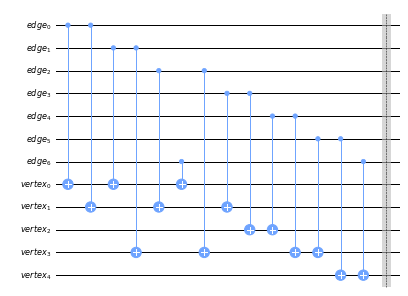

In [ ]:
graph_encoding().draw('mpl', scale=0.5, fold=-1)

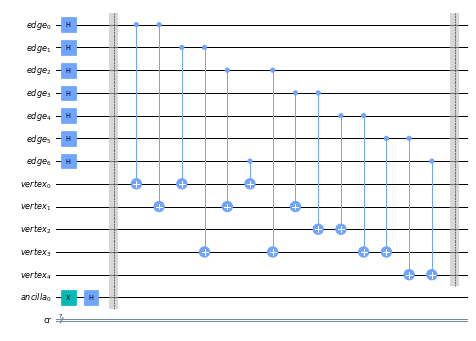

In [ ]:
qc = qc.compose(initialize())
qc = qc.compose(graph_encoding())
qc.draw('mpl', scale=0.5, fold=-1)

In [ ]:
#flip phase of the solutions
def flip():
    fp = QuantumCircuit(edge, vertex, ancilla)
    fp.x([vertex[1],vertex[3],vertex[4]])
    #fp.x([vertex[0],vertex[1],vertex[2],vertex[3],vertex[4]])
    fp.mct([vertex[i] for i in range(len(vertex))], ancilla[0])
    #fp.x([vertex[0],vertex[1],vertex[2],vertex[3],vertex[4]])
    fp.x([vertex[1],vertex[3],vertex[4]])
    fp.barrier()
    return fp

The phase inversion operation is intended to invert the phase of the sought state HP. The HP is not known, but we know the final vertex state for a HP, as we saw in the example. In order to reverse the phase of the mapped edges state, we can apply the operation in the vertex register.

\begin{equation}
  |\psi\rangle = \frac{1}{\sqrt{2^b}} \sum |path_x\rangle \otimes (-1)|10100\rangle = \frac{1}{\sqrt{2^ b}} \sum (-1)|path_x\rangle \otimes|10100\rangle
\end{equation}


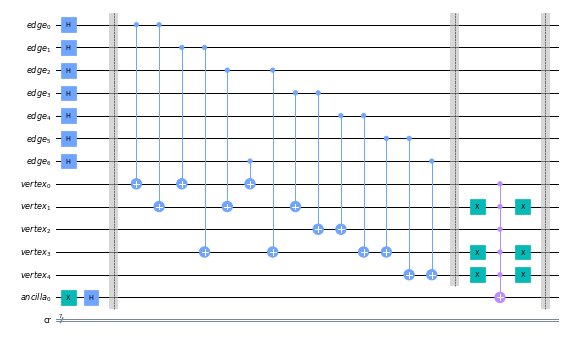

In [ ]:
qc = qc.compose(flip())
qc.draw('mpl',scale=0.5,fold=-1)

In [ ]:
qc = qc.compose(graph_encoding())

In [ ]:
#Diffuser operator to perform an inversion about the mean
def diffuser():
    dif = QuantumCircuit(edge)
    dif.h(range(len(edge)))
    dif.x(range(len(edge)))
    dif.h(edge[-1])
    dif.mct([edge[i] for i in range(len(edge)-1)], edge[-1])
    dif.h(edge[-1])
    dif.x(range(len(edge)))
    dif.h(range(len(edge)))
    dif.barrier()
    return dif

In [ ]:
#Creating Grover iterations
qc = qc.compose(diffuser())

qc.barrier()
qc = qc.compose(graph_encoding())
qc = qc.compose(flip())
qc = qc.compose(graph_encoding())
qc = qc.compose(diffuser())

qc = qc.compose(graph_encoding())
qc = qc.compose(flip())
qc = qc.compose(graph_encoding())
qc = qc.compose(diffuser())

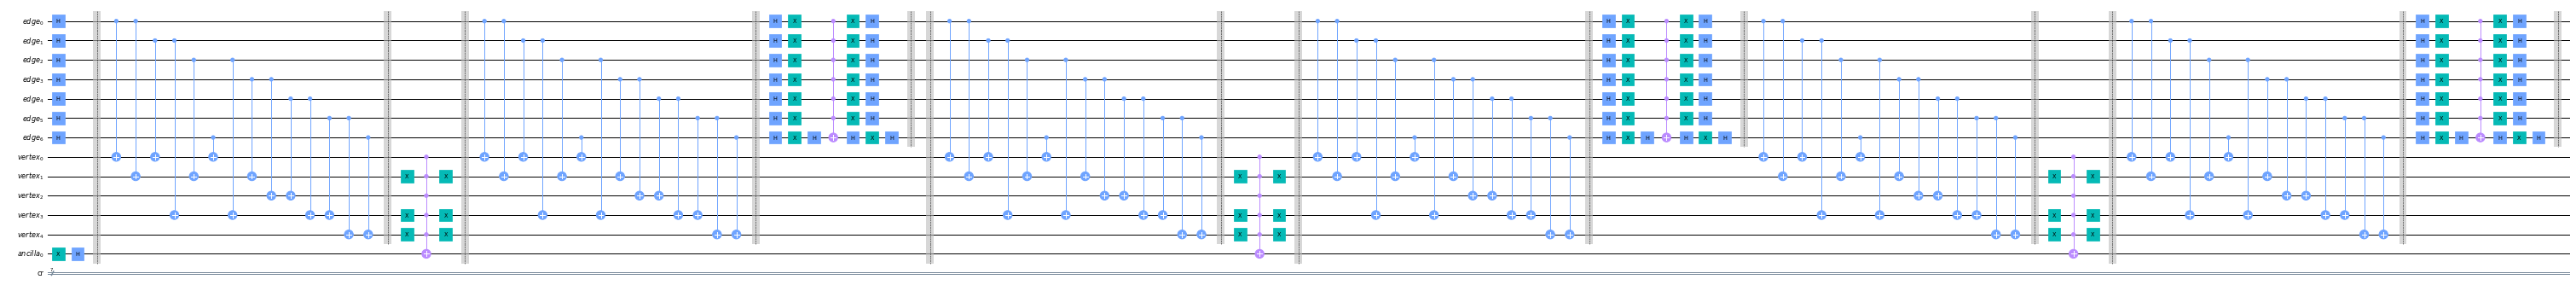

In [ ]:
qc.draw('mpl', scale=0.5, fold=-1)

In [ ]:
qc.measure(range(len(edge)), range(len(edge)))

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=1024).result().get_counts(qc)


In [ ]:
# removing paths with more than n-1 steps
oneslist = list()
for key, value in counts.items():
    if key.count('1') >= 5: oneslist.append(key)

for i in range(len(oneslist)):  del counts[oneslist[i]]

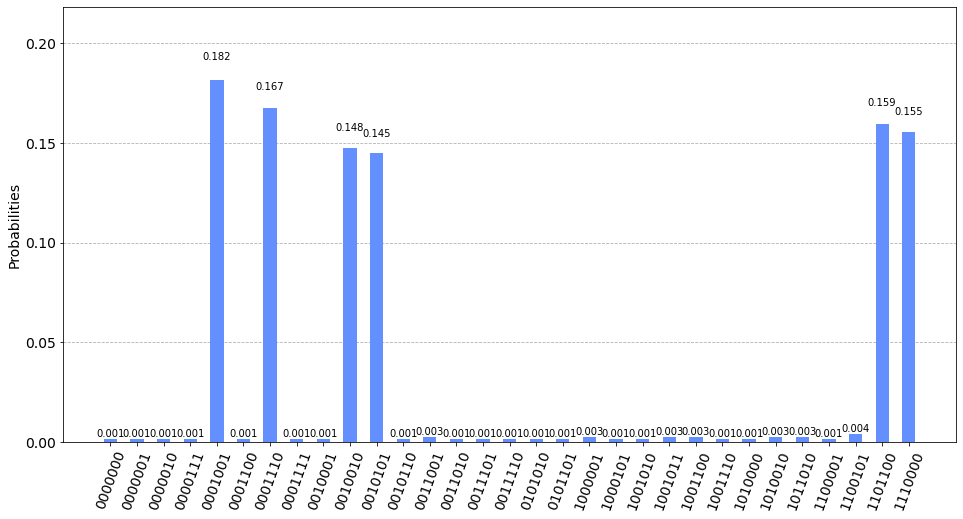

In [ ]:
import matplotlib.pyplot as plt
plot_histogram(counts, figsize=(16,8)) 

# Conclusion

We show that it is possible to find paths in graphs using Grover's algorithm. Paths that travel more than $n-1$ (where $n$ is the number of vertices in the graph) edges can be disregarded in the measurements, as they represent paths with repeated vertices. The implemented algorithm demonstrates quadratic speed up compared to a classic brute force algorithm.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright